In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L1L2

In [ ]:
data = pd.read_csv('/content/Olympic_Swimming_Results_1912to2020.csv')

In [ ]:
def convert_to_seconds(time_str):
    if any(char.isalpha() for char in time_str):
        return None
    parts = time_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = parts
        return int(hours) * 3600 + int(minutes) * 60 + float(seconds)
    elif len(parts) == 2:
        minutes, seconds = parts
        return int(minutes) * 60 + float(seconds)
    try:
        return float(time_str)
    except ValueError:
        return None

In [ ]:
data['Results'] = data['Results'].astype(str)
data['Results_in_seconds'] = data['Results'].apply(convert_to_seconds)
data.dropna(subset=['Results_in_seconds'], inplace=True)

In [ ]:
# filter 100 fr
data = data[(data['Distance (in meters)'] == '100m') & (data['Stroke'] == 'Freestyle')]

In [ ]:
print(data.describe())

              Year  Relay?        Rank  Results_in_seconds
count   371.000000   371.0  371.000000          371.000000
mean   1973.606469     0.0    3.180593           57.118868
std      29.951427     0.0    1.116099            7.629390
min    1912.000000     0.0    1.000000           47.020000
25%    1952.000000     0.0    2.000000           51.780000
50%    1976.000000     0.0    4.000000           55.590000
75%    2000.000000     0.0    4.000000           60.500000
max    2020.000000     0.0    4.000000           87.400000


In [ ]:
X = data[['Year', 'Gender', 'Team', 'Stroke', 'Distance (in meters)']]
y = data['Results_in_seconds']

In [ ]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Team', 'Stroke', 'Distance (in meters)'])
    ]
)

In [ ]:
# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [ ]:
X_train_encoded = preprocessor.fit_transform(X_train)

In [ ]:
X_test_encoded = preprocessor.transform(X_test)

In [ ]:
# reshaping for model input
X_train_reshaped = X_train_encoded.toarray().reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_reshaped = X_test_encoded.toarray().reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, kernel_regularizer=L1L2(l1=0.01, l2=0.01), input_shape=(1, X_train_reshaped.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=L1L2(l1=0.01, l2=0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# needs to be type float
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [ ]:
# taining
history = model.fit(X_train_reshaped, y_train, epochs=200, batch_size=1,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping], verbose = 0)

In [ ]:
# loss evaluation
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}')

2/2 [==============================] - 1s 33ms/step - loss: 11.5476 - mean_squared_error: 3.0369
Test Loss: [11.547612190246582, 3.0369205474853516]


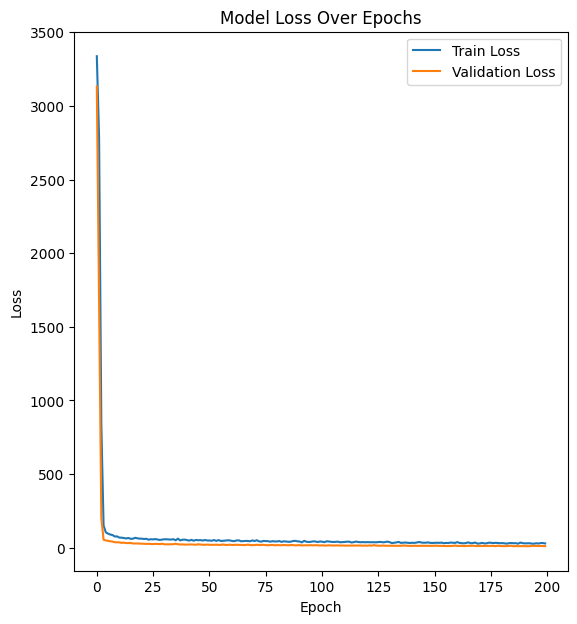

In [ ]:
# plot loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# data for prediction
years = [2024, 2028, 2032, 2036, 2040]
teams = ['USA', 'China', 'Russia', 'Canada', 'Australia', 'France']
genders = ['Men', 'Women']

future_data = pd.DataFrame({
    'Year': [year for year in years for _ in range(len(teams) * len(genders))],
    'Gender': [gender for _ in years for gender in genders for _ in teams],
    'Team': teams * len(genders) * len(years),
    'Stroke': ['Freestyle'] * len(teams) * len(genders) * len(years),
    'Distance (in meters)': ['100m'] * len(teams) * len(genders) * len(years)
})

# preprocess prediction data
future_encoded = preprocessor.transform(future_data)
future_reshaped = future_encoded.toarray().reshape((future_encoded.shape[0], 1, future_encoded.shape[1]))

# make preds
predicted_times = model.predict(future_reshaped)
future_data['Predicted Time'] = predicted_times.flatten()

winners = future_data.loc[future_data.groupby(['Year', 'Gender'])['Predicted Time'].idxmin()]
print("Predicted winners for the next five Olympics:")
print(winners)

2/2 [==============================] - 1s 4ms/step
Predicted winners for the next five Olympics:
    Year Gender Team     Stroke Distance (in meters)  Predicted Time
0   2024    Men  USA  Freestyle                 100m       45.986004
6   2024  Women  USA  Freestyle                 100m       50.536121
12  2028    Men  USA  Freestyle                 100m       45.661057
18  2028  Women  USA  Freestyle                 100m       50.066299
24  2032    Men  USA  Freestyle                 100m       45.348873
30  2032  Women  USA  Freestyle                 100m       49.619896
36  2036    Men  USA  Freestyle                 100m       45.048668
42  2036  Women  USA  Freestyle                 100m       49.195229
48  2040    Men  USA  Freestyle                 100m       44.759701
54  2040  Women  USA  Freestyle                 100m       48.790718


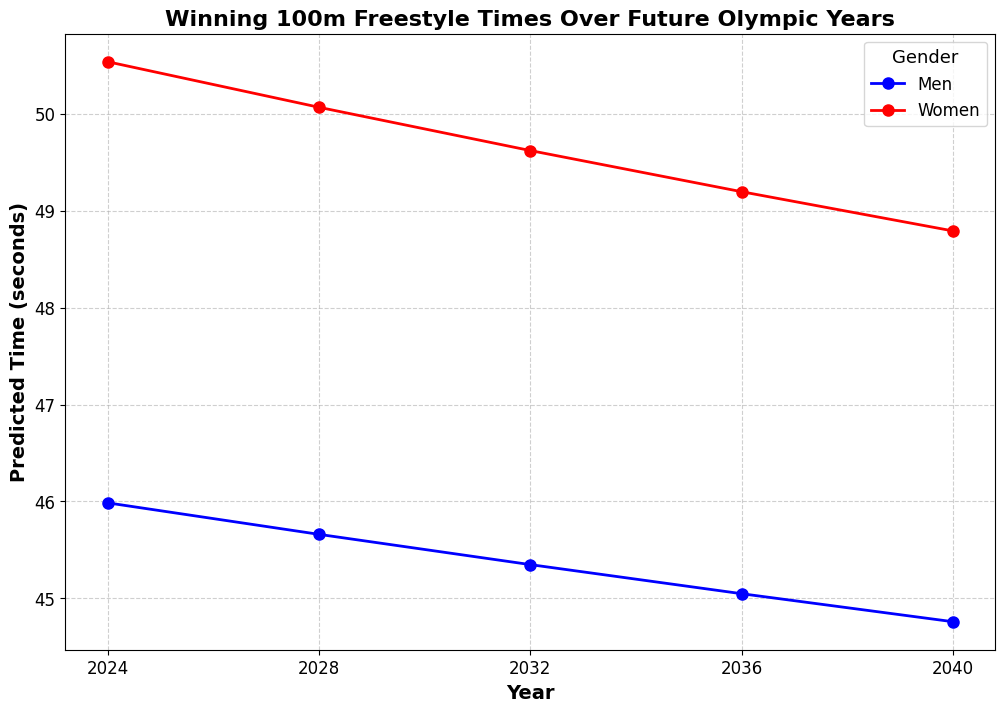

In [ ]:
# plot preds
plt.figure(figsize=(12, 8))
colors = {'Men': 'blue', 'Women': 'red'}

for gender in winners['Gender'].unique():
    subset = winners[winners['Gender'] == gender]
    plt.plot(subset['Year'], subset['Predicted Time'], marker='o', linestyle='-', linewidth=2, markersize=8, color=colors[gender], label=gender)

plt.title('Winning 100m Freestyle Times Over Future Olympic Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Time (seconds)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Gender', title_fontsize='13', fontsize='12')
plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


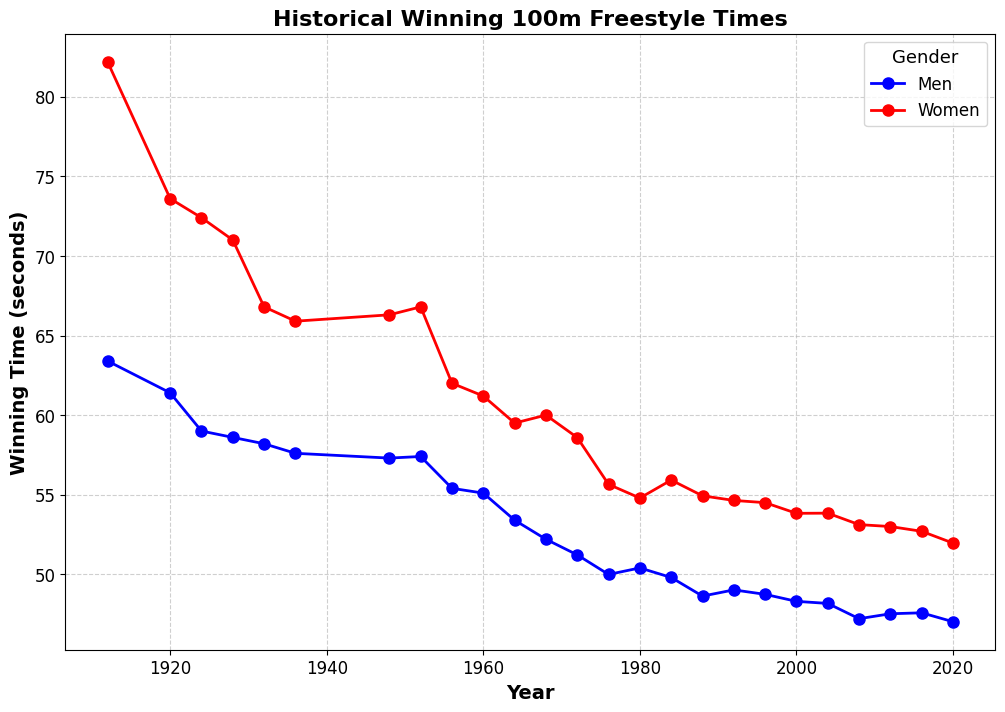

In [ ]:
historical_data = data[(data['Distance (in meters)'] == '100m') & (data['Stroke'] == 'Freestyle')]

historical_winners = historical_data.loc[historical_data.groupby(['Year', 'Gender'])['Results_in_seconds'].idxmin()]


plt.figure(figsize=(12, 8))
colors = {'Men': 'blue', 'Women': 'red'}

for gender in historical_winners['Gender'].unique():
    subset = historical_winners[historical_winners['Gender'] == gender]
    plt.plot(subset['Year'], subset['Results_in_seconds'], marker='o', linestyle='-', linewidth=2, markersize=8, color=colors[gender], label=gender)

plt.title('Historical Winning 100m Freestyle Times', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Winning Time (seconds)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Gender', title_fontsize='13', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


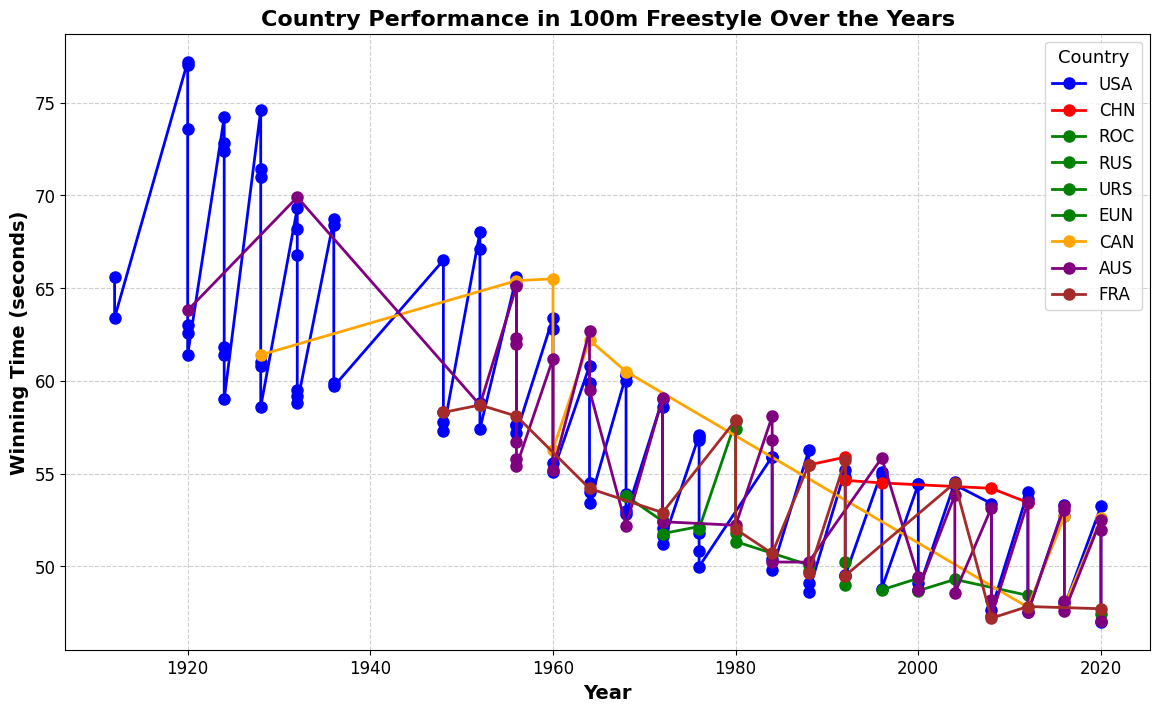

In [ ]:
selected_countries = ['USA', 'CHN', 'ROC', 'RUS', 'URS', 'EUN', 'CAN', 'AUS', 'FRA']
country_performance_filtered = historical_data[historical_data['Team'].isin(selected_countries)]

plt.figure(figsize=(14, 8))
colors = {'USA': 'blue', 'CHN': 'red', 'ROC': 'green', 'RUS': 'green', 'URS': 'green', 'EUN': 'green', 'CAN': 'orange', 'AUS': 'purple', 'FRA': 'brown'}

for country in selected_countries:
    subset = country_performance_filtered[country_performance_filtered['Team'] == country]
    plt.plot(subset['Year'], subset['Results_in_seconds'], marker='o', linestyle='-', linewidth=2, markersize=8, color=colors[country], label=country)

plt.title('Country Performance in 100m Freestyle Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Winning Time (seconds)', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Country', title_fontsize='13', fontsize='12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()